In [1]:
from copy import deepcopy
import json
import pickle 


from gears import PertData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

/home/users/geroldcsendes/miniconda3/envs/scgpt_2_clone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


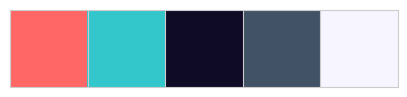

In [2]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [3]:
def mean_predictor(perturbation_dict, pert_data, key_pattern, is_norman: bool, add_valid: bool = False):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20

    def _filt_self_from_de(pert_data, is_norman: bool):
        gene_name_to_ensg = dict(zip(pert_data.adata.var["gene_name"], pert_data.adata.var.index))
        rank_genes_groups_cov_all = deepcopy(pert_data.adata.uns[DE_COL])

        updated_rank_genes_groups_cov_all = {}

        for k, v in rank_genes_groups_cov_all.items():
            condition = k.split("_")[1]
            condition_gene_name = condition.replace("ctrl+", "").replace("+ctrl", "")

            if is_norman:
                condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
            else:
                if "+" in condition_gene_name:
                    condition_gene_name = condition_gene_name.split("+")
                    assert len(condition_gene_name) == 2
                    condition_ensg_name = [gene_name_to_ensg.get(g, None) for g in condition_gene_name]
                    mask = ~np.isin(v, condition_ensg_name)
                    updated_rank_genes_groups_cov_all[k] = v[mask]
                else:
                    condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                    updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]

        return updated_rank_genes_groups_cov_all

    de_dict =  pert_data.adata.uns[DE_COL]
    de_dict_noself = _filt_self_from_de(pert_data, is_norman)

    _perturbation_dict = deepcopy(perturbation_dict)
    train_samples = _perturbation_dict['train'] if not add_valid else _perturbation_dict['train'] + _perturbation_dict['val']
    test_samples = _perturbation_dict['test']
    train_samples.remove('ctrl')

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    # keep for raw corr calculation
    data_raw = data.copy()
    data_raw = data_raw.drop('ctrl')
    train_mean_raw = data_raw.loc[train_samples].mean()

    data = data - data.loc['ctrl']
    data = data.drop('ctrl')
    train_mean = data.loc[train_samples].mean()

    # calculate raw pearson
    rs = []
    for sample in test_samples:
        rs.append(pearsonr(train_mean_raw, data_raw.loc[sample])[0])
    rs = pd.Series(rs, index=test_samples)
    pearson_raw = rs.mean()
    print("Pearson raw: ", rs.mean())

    # calculate pearson_delta
    rs = []
    for sample in test_samples:
        rs.append(pearsonr(train_mean, data.loc[sample])[0])
    
    rs = pd.Series(rs, index=test_samples)
    pearson_delta = rs.mean()
    print("Pearson delta: ", rs.mean())

    # calculate pearson_delta_DE
    rs = []
    for sample in test_samples:
        de = de_dict[key_pattern % sample][:20]
        rs.append(pearsonr(train_mean[de], data.loc[sample, de])[0])

    rs = pd.Series(rs, index=test_samples)
    pearson_delta_de = rs.mean()
    print("Pearson delta DE: ", rs.mean())

    # calculate pearson_delta_DE without knockout DE
    rs = []
    for sample in test_samples:
        de = de_dict_noself[key_pattern % sample][:20]
        rs.append(pearsonr(train_mean[de], data.loc[sample, de])[0])

    rs = pd.Series(rs, index=test_samples)
    pearson_delta_de_no_knockout = rs.mean()
    print("Pearson delta DE no knockout: ", rs.mean())

    return dict(
        pearson=pearson_raw,
        pearson_delta=pearson_delta,
        pearson_de_delta=pearson_delta_de,
        pearson_delta_de_no_knockout=pearson_delta_de_no_knockout)


In [4]:
def plot_results(res_scgpt, res_mean, ds):
    df = pd.DataFrame(data=dict(scgpt=res_scgpt, mean=res_mean))
    my = df.T.reset_index().rename(columns={"index": "model"})
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    sns.barplot(x='model', y='pearson', data=my, ax=axs[0])
    sns.barplot(x='model', y='pearson_delta', data=my, ax=axs[1])
    sns.barplot(x='model', y='pearson_de_delta', data=my, ax=axs[2])
    sns.barplot(x='model', y='pearson_delta_de_no_knockout', data=my, ax=axs[3])

    axs[0].set_title(f"{ds} Pearson Results")
    axs[1].set_title(f"{ds} Pearson Delta Results")
    axs[2].set_title(f"{ds} Pearson Delta DE Results")
    axs[3].set_title(f"{ds} Pearson Delta DE No Knockout Results")

    plt.tight_layout()
    plt.show()

In [5]:
BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64

## Adamson

In [6]:
with open("save/dev_perturb_adamson-Sep26-20-36/test_metrics.json") as f:
    res_adamson_scgpt = json.load(f)

# res_adamson_scgpt = {k: v for k, v in res_adamson_scgpt.items() if "delta" in k}
res_adamson_scgpt

{'pearson': 0.9904044636295309,
 'pearson_de': 0.9793934257161502,
 'pearson_delta': 0.6410384627817425,
 'pearson_de_delta': 0.797411136795439,
 'pearson_delta_de_no_knockout': 0.7946322223752247}

In [7]:
pert_data_adamson = PertData("./data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)
pert_data_adamson.get_dataloader(batch_size=BATCH_SIZE, test_batch_size=EVAL_BATCH_SIZE)

with open('./data/adamson/splits/adamson_simulation_1_0.75.pkl', 'br') as fin:
    _ = pickle.load(fin)
perturbation_dict_pert_data_adamson = deepcopy(_)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!
Creating dataloaders....
Done!


In [8]:
res_adamson_mean = mean_predictor(
    perturbation_dict=perturbation_dict_pert_data_adamson,
    pert_data=pert_data_adamson,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False,
)

Pearson raw:  0.9925863649524949
Pearson delta:  0.7111481350358023
Pearson delta DE:  0.7292645091249679
Pearson delta DE no knockout:  0.7845348499382115


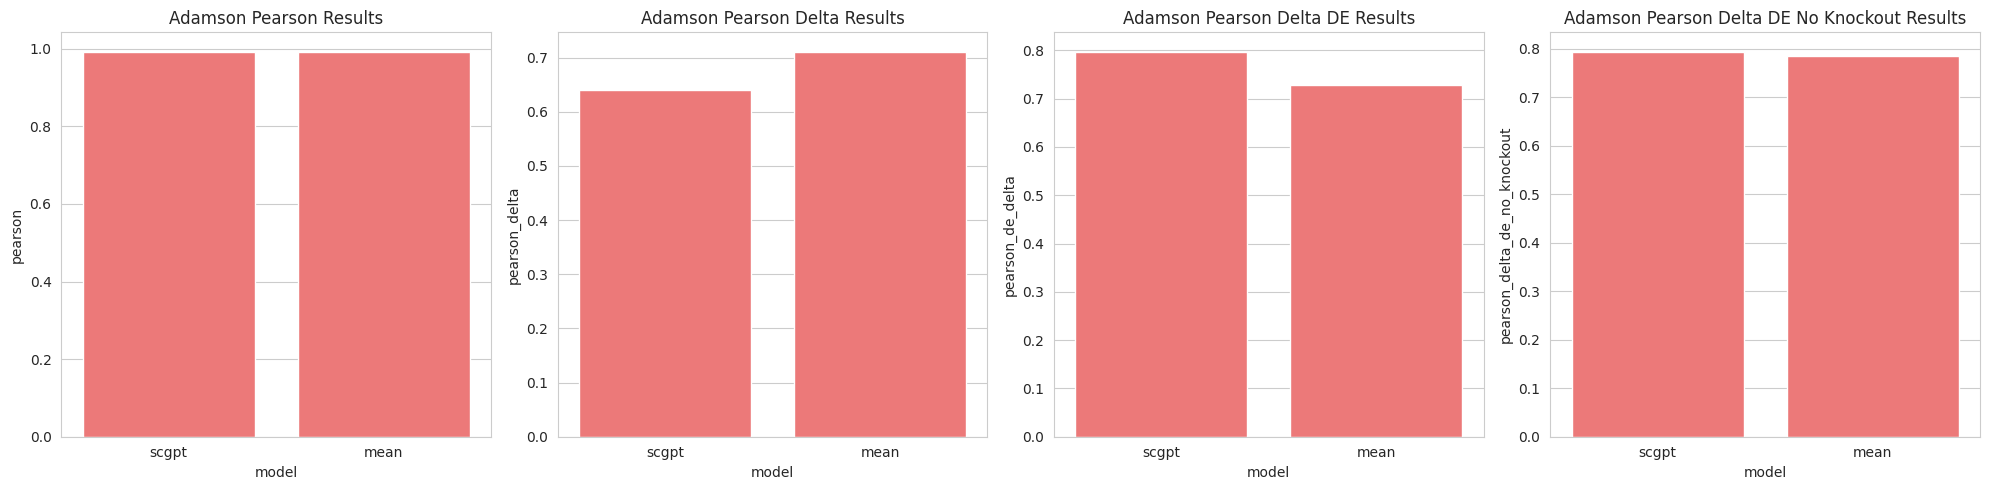

In [9]:
plot_results(res_adamson_scgpt, res_adamson_mean, "Adamson")

## Norman

In [6]:
with open("save/dev_perturb_norman-Sep24-13-29/test_metrics.json") as f:
    res_norman_scgpt = json.load(f)
res_norman_scgpt

{'pearson': 0.9876885004486825,
 'pearson_de': 0.9346868607697523,
 'pearson_delta': 0.5538380087496604,
 'pearson_de_delta': 0.7318224946102615,
 'pearson_delta_de_no_knockout': 0.6998551124777874}

In [7]:
pert_data_norman = PertData("./data/")
pert_data_norman.load(data_path='data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)
pert_data_norman.get_dataloader(batch_size=BATCH_SIZE, test_batch_size=EVAL_BATCH_SIZE)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!
Creating dataloaders....
Done!


In [8]:
with open('./data/norman/splits/_simulation_1_0.75.pkl', 'br') as fin:
    _ = pickle.load(fin)

perturbation_dict_norman = deepcopy(_)

In [9]:
res_norman_mean = mean_predictor(
    perturbation_dict=perturbation_dict_norman,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True,
)

Pearson raw:  0.9862726295720105
Pearson delta:  0.5572658039397808
Pearson delta DE:  0.579527478844477
Pearson delta DE no knockout:  0.6005358512842587


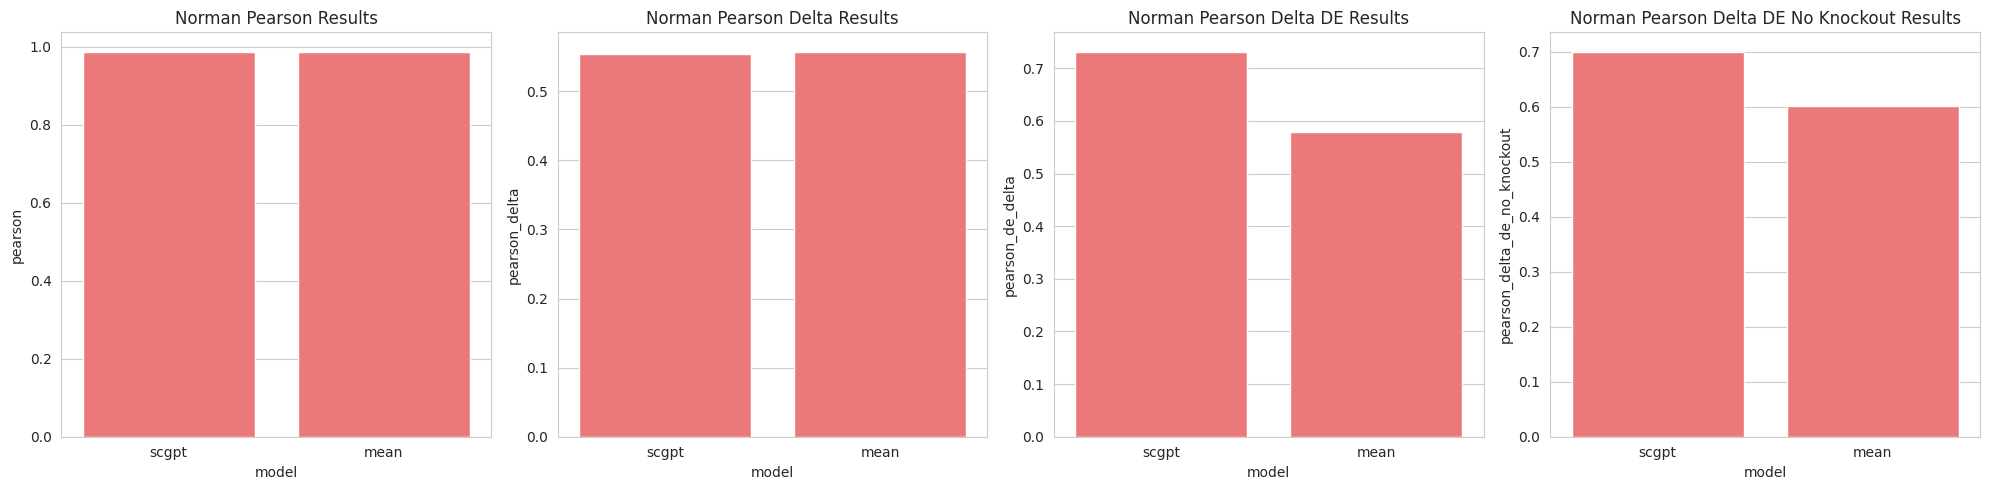

In [10]:
plot_results(res_norman_scgpt, res_norman_mean, "Norman")

## Replogle

In [12]:
with open("save/dev_perturb_replogle-Sep24-15-06/test_metrics.json") as f:
    res_replogle_scgpt = json.load(f)
res_replogle_scgpt

{'pearson': 0.9863408854533723,
 'pearson_de': 0.9597633761072804,
 'pearson_delta': 0.32650210867207097,
 'pearson_de_delta': 0.48096555832597354,
 'pearson_delta_de_no_knockout': 0.4423887584863228}

In [7]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)
pert_data_replogle.get_dataloader(batch_size=BATCH_SIZE, test_batch_size=EVAL_BATCH_SIZE)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!
Creating dataloaders....
Done!


In [8]:
with open('data/replogle_k562_essential/splits/_simulation_1_0.75.pkl', 'br') as fin:
    perturbation_dict_replogle = pickle.load(fin)

In [9]:
res_replogle_mean = mean_predictor(
    perturbation_dict=perturbation_dict_replogle,
    pert_data=pert_data_replogle,
    key_pattern="K562_%s_1+1",
    is_norman=False,
)

Pearson raw:  0.9873844490732891
Pearson delta:  0.3729958131954014
Pearson delta DE:  0.4359587549260434
Pearson delta DE no knockout:  0.4585350881456312


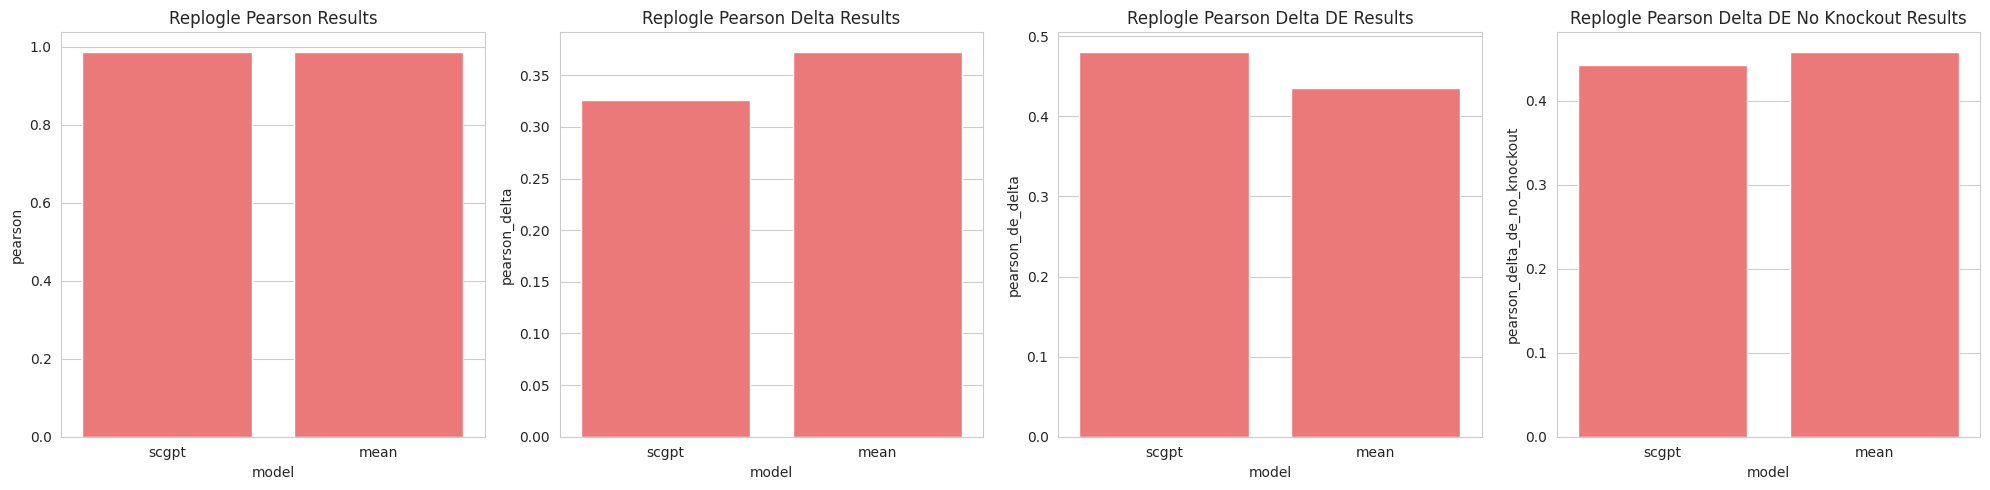

In [13]:
plot_results(res_replogle_scgpt, res_replogle_mean, "Replogle")